# Loading in the data

In [1]:
import pandas as pd
import numpy as np
import warnings

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
fraud_df = pd.read_csv('synthetic_financial_data.csv')
fraud_df.head()

,transaction_id,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description
0,1,1082,2027,5758.59,2023-01-01 00:00:00,0,MasterCard,City-30,Gas Station,43,Purchase at Merchant-2027
1,2,1015,2053,1901.56,2023-01-01 00:00:01,1,Visa,City-47,Online Shopping,61,Purchase at Merchant-2053
2,3,1004,2035,1248.86,2023-01-01 00:00:02,1,MasterCard,City-6,Gas Station,57,Purchase at Merchant-2035
3,4,1095,2037,7619.05,2023-01-01 00:00:03,1,Discover,City-6,Travel,59,Purchase at Merchant-2037
4,5,1036,2083,1890.10,2023-01-01 00:00:04,1,MasterCard,City-34,Retail,36,Purchase at Merchant-2083


In [3]:
# Checking the raw size of the dataframe
fraud_df.shape

(10000, 11)

In [4]:
# Removing columns that wont be used in the model
drop_df = fraud_df.drop(['transaction_id', 'customer_id', 'transaction_time', 'location', 'transaction_description'], axis=1)
drop_df.head()

,merchant_id,amount,is_fraudulent,card_type,purchase_category,customer_age
0,2027,5758.59,0,MasterCard,Gas Station,43
1,2053,1901.56,1,Visa,Online Shopping,61
2,2035,1248.86,1,MasterCard,Gas Station,57
3,2037,7619.05,1,Discover,Travel,59
4,2083,1890.10,1,MasterCard,Retail,36


In [5]:
drop_df.shape

(10000, 6)

# Cleansing

In [6]:
# Checking for null fields
drop_df.isnull().sum()   # no null fields present

merchant_id          0
amount               0
is_fraudulent        0
card_type            0
purchase_category    0
customer_age         0
dtype: int64

In [7]:
# Checking data types
drop_df.dtypes

merchant_id            int64
amount               float64
is_fraudulent          int64
card_type             object
purchase_category     object
customer_age           int64
dtype: object

In [8]:
# Creating dummy variables for the string type features
dummy_df = pd.get_dummies(drop_df, columns=['card_type', 'purchase_category'], drop_first=True)
dummy_df.head()

,merchant_id,amount,is_fraudulent,customer_age,card_type_Discover,card_type_MasterCard,card_type_Visa,purchase_category_Groceries,purchase_category_Online Shopping,purchase_category_Restaurant,purchase_category_Retail,purchase_category_Travel
0,2027,5758.59,0,43,0,1,0,0,0,0,0,0
1,2053,1901.56,1,61,0,0,1,0,1,0,0,0
2,2035,1248.86,1,57,0,1,0,0,0,0,0,0
3,2037,7619.05,1,59,1,0,0,0,0,0,0,1
4,2083,1890.10,1,36,0,1,0,0,0,0,1,0


# Visualizing

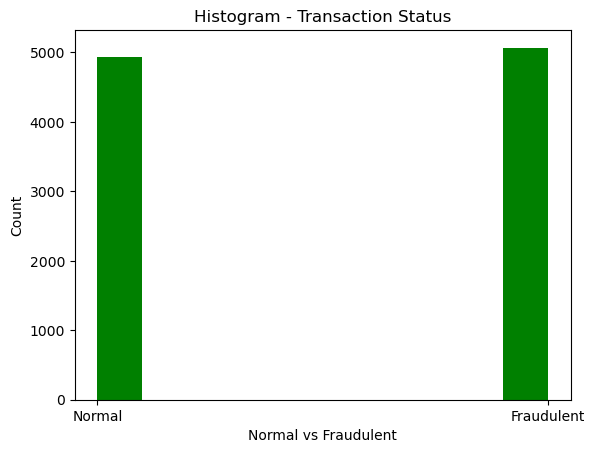

In [9]:
plt.hist(dummy_df['is_fraudulent'], color='green')
plt.xlabel('Normal vs Fraudulent')
plt.xticks(ticks=[0,1], labels=['Normal','Fraudulent'])
plt.ylabel('Count')
plt.title('Histogram - Transaction Status')
plt.show()

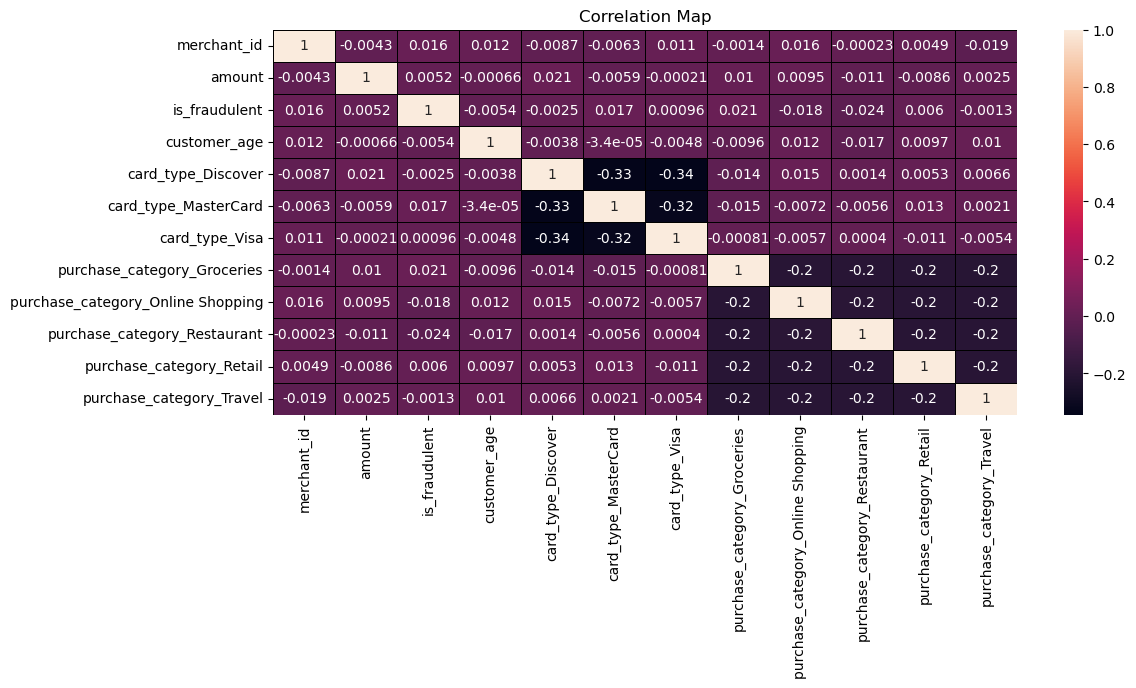

In [10]:
# Checking the correlations amongst the usable features
correlation = dummy_df.corr(numeric_only=True)

plt.figure(figsize=(12,5))
sns.heatmap(correlation, linewidths=0.5, linecolor='black', annot=True)
plt.title('Correlation Map')
plt.show()

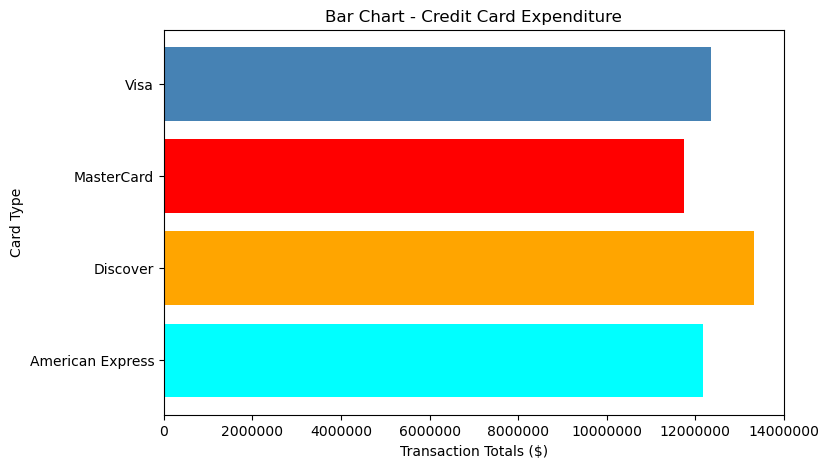

In [32]:
# Groupin the cards by type, calculating the total expendature, and then visualizing how they compare
sums_df = drop_df.groupby('card_type')['amount'].sum()
sums_df.values

plt.figure(figsize=(8,5))
plt.barh(sums_df.index, sums_df.values, color=['cyan', 'orange', 'red', 'steelblue'])
plt.ticklabel_format(style='plain', axis='x')
plt.xlabel('Transaction Totals ($)')
plt.ylabel('Card Type')
plt.title('Bar Chart - Credit Card Expenditure')
plt.xlim([0,14000000])
plt.show()

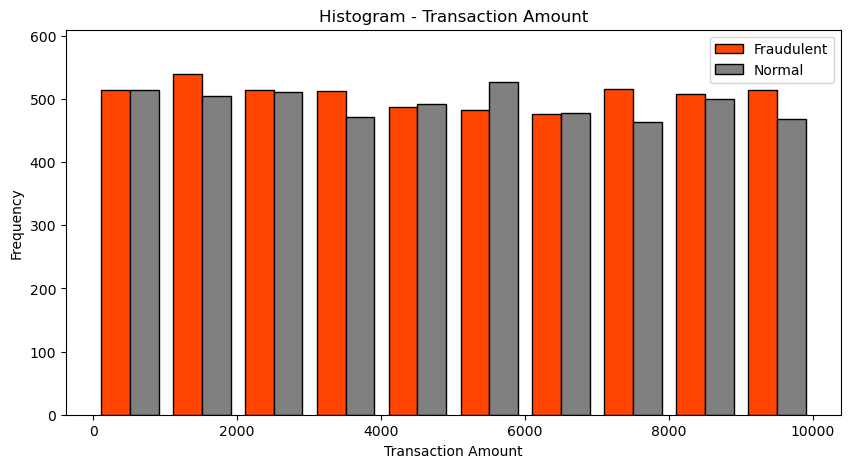

In [12]:
# Creating dataframes that contain either only fraudulent or normal transactions
fraudulent = drop_df[drop_df['is_fraudulent']==1]
normal = drop_df[drop_df['is_fraudulent']==0]

plt.figure(figsize=(10,5))
plt.hist([fraudulent['amount'], normal['amount']], color=['orangered','grey'], edgecolor='black')

plt.legend(['Fraudulent', 'Normal'])
plt.title('Histogram - Transaction Amount')
plt.xlabel('Transaction Amount')
plt.ylim([0,610])
plt.ylabel('Frequency')
plt.show()

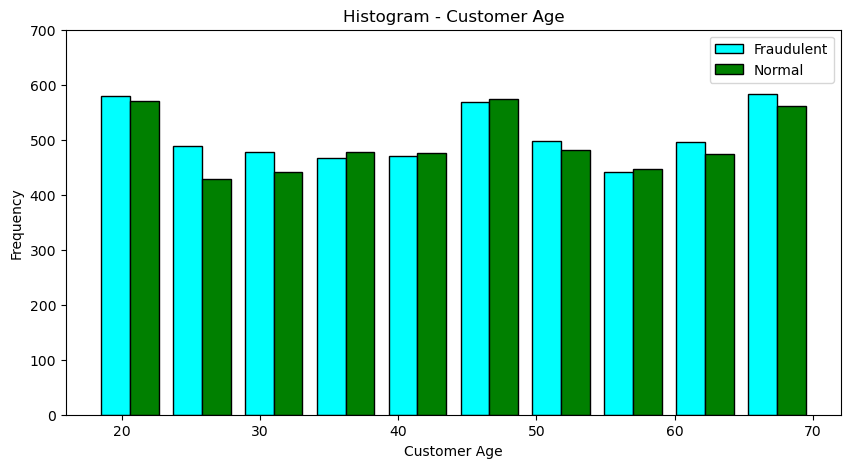

In [33]:
# Visualizing the distribution of age against normal and fraudulent transactions
plt.figure(figsize=(10,5))
plt.hist([fraudulent['customer_age'], normal['customer_age']], color=['cyan','green'], edgecolor='black')

plt.legend(['Fraudulent', 'Normal'])
plt.xlabel('Customer Age')
plt.ylim([0,700])
plt.ylabel('Frequency')
plt.title('Histogram - Customer Age')
plt.show()

In [14]:
drop_df['card_type'].value_counts()

Discover            2633
American Express    2494
Visa                2490
MasterCard          2383
Name: card_type, dtype: int64

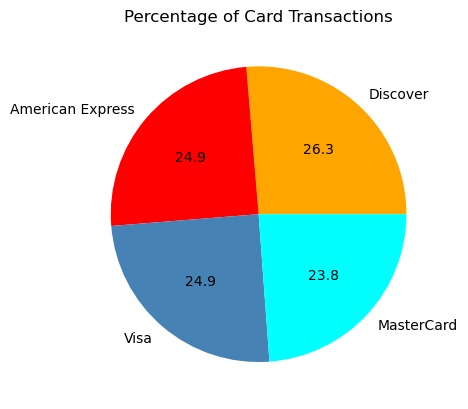

In [30]:
cards = drop_df['card_type'].value_counts()
color=['orange', 'red', 'steelblue', 'cyan']

plt.pie(cards, labels=cards.index, colors=color, autopct = '%.1f')
plt.title('Percentage of Card Transactions')
plt.show()

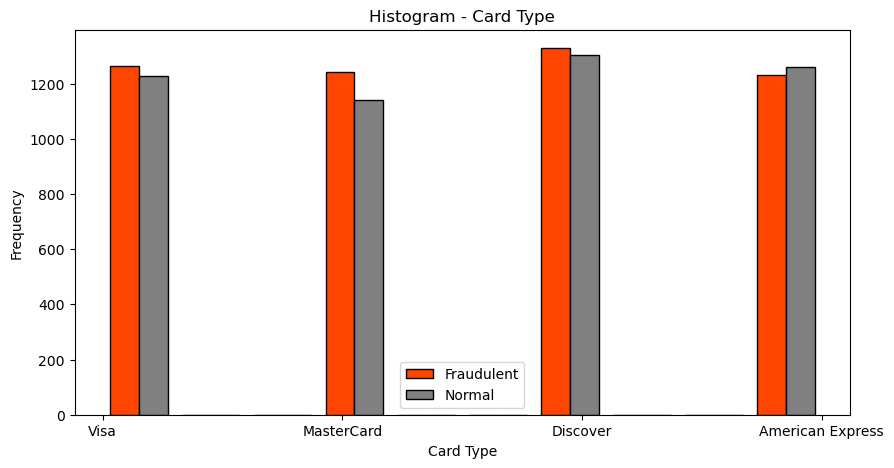

In [34]:
plt.figure(figsize=(10,5))
plt.hist([fraudulent['card_type'], normal['card_type']], color=['orangered','grey'], edgecolor='black')

plt.legend(['Fraudulent', 'Normal'])
plt.xlabel('Card Type')
plt.ylabel('Frequency')
plt.title('Histogram - Card Type')
plt.show()

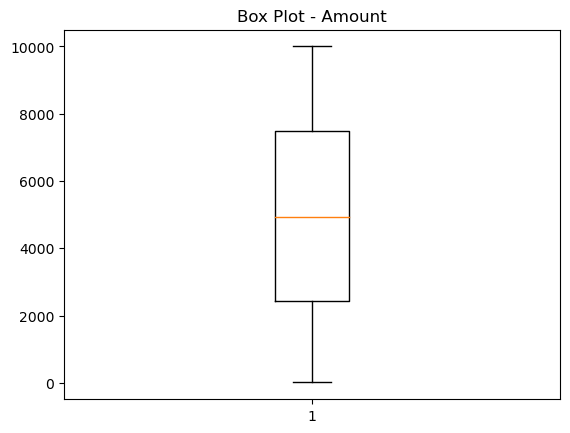

In [35]:
plt.boxplot(drop_df['amount'])
plt.title('Box Plot - Amount')
plt.show()

# Model Preparation

In [18]:
# Creating dataframes specific to the target and feature column/s
target_df = dummy_df['is_fraudulent']
features_df = dummy_df.drop(['is_fraudulent'], axis=1)
features_df.shape

(10000, 11)

In [19]:
# Scaling the feature dataframe as the values amongst each column cover a wide range
scaled_features = StandardScaler().fit_transform(features_df)

X_train, X_test, y_train, y_test = train_test_split(scaled_features, target_df, train_size=0.8, random_state=10)
print(f'X_train:{X_train.shape}, X_test:{X_test.shape}\ny_train: {y_train.shape[0]}, y_test: {y_test.shape[0]}')

X_train:(8000, 11), X_test:(2000, 11)
y_train: 8000, y_test: 2000


# Model Creating and Metrics

In [20]:
# Creating instances of the models to be used in a dictionary with the corresponding name for future dataframe usage
lrrfc = {'Logistic Regression': LogisticRegression(random_state=20), 
         'Random Forest Classifier': RandomForestClassifier(random_state=20)}

# Initiating a dictionary that will contain each models metrics
met_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'TP', 'FP', 'FN', 'TN'])

In [21]:
# Function that will take our model dictionary as a parameter and build the models
def modeling(models):
    for name, model in models.items():
        model.fit(X_train, y_train)
        prediction = model.predict(X_test)
        
        # This section calculates the model metrics and updates the metric dataframe
        cm = confusion_matrix(prediction, y_test)
        accu = round(accuracy_score(prediction, y_test), 3)*100
        precision = round(precision_score(prediction, y_test), 3)*100
        recall = round(recall_score(prediction, y_test), 3)*100
        f1 = round(f1_score(prediction, y_test), 3)*100
        
        
        met_df.loc[len(met_df)] = [name, accu, precision, recall, f1, cm[0][0], cm[0][1], cm[1][0], cm[1][1]]   
                
    return met_df 

In [22]:
# Passing the model dictionary as an argument then storing to a variable that will have a dataframe returned
lr_rf_mets = modeling(lrrfc)
lr_rf_mets 

,Model,Accuracy,Precision,Recall,F1,TP,FP,FN,TN
0,Logistic Regression,51.6,53.1,54.8,53.9,467,500,467,566
1,Random Forest Classifier,48.6,48.3,51.9,50.0,457,551,477,515


# Grid Search

In [23]:
# Initializing the Pipeline
pipe = Pipeline(steps = [('classifier', LogisticRegression())])

# Adding the parameters to be explored for both a Logistic Regression and Random Forest Classifier
param_grid = [
    {
    'classifier':[LogisticRegression()],
    'classifier__penalty': ['l1', 'l2', 'elasticnet'],
    'classifier__C': np.logspace(-4, 4, 20),
    'classifier__solver' : ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'],
    'classifier__max_iter' : [80, 100, 150]               
    }, 
    {
    'classifier':[RandomForestClassifier()],
    'classifier__n_estimators' : (150, 200, 250),
    'classifier__max_features' : ['auto', 'log2'],
    'classifier__max_depth' : [2, 5], 
    'classifier__min_samples_split' : [3, 5, 6],
    'classifier__min_samples_leaf' : [3, 4, 5],
    'classifier__bootstrap': [True, False]         
    }
]

In [24]:
# Initializing the GridSearchCV with the pipeline and corresponding parameters created above.
# Metric focus is on the model with the best precision score
gs_cv = GridSearchCV(pipe, param_grid, scoring='precision' , refit='precision' , cv=3, verbose=2, n_jobs=2)

In [25]:
# This function is designed to accept the GridSearchCV, conceal the warnings and errors that involve parameters not working with
# one another and then returning the trained model.
def gridsearch_pipeline(gs_inst):
    warnings.filterwarnings(action='ignore')
    try:
        trained_gs = gs_inst.fit(X_train, y_train)
        return trained_gs
    except Exception as e:
        print(e)

In [26]:
# Initiating a dictionary that will contain the model metrics
gs_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'TP', 'FP', 'FN', 'TN'])

# Function created to accept the prediction data, calculate the model metrics, and update the metric dataframe
def logreg_metrics(pred):
        name = 'Logistic Regression (Grid Searched)'
        cm = confusion_matrix(pred, y_test)
        accu = round(accuracy_score(pred, y_test), 3)*100
        precision = round(precision_score(pred, y_test), 3)*100
        recall = round(recall_score(pred, y_test), 3)*100
        f1 = round(f1_score(pred, y_test), 3)*100
        
        gs_df.loc[len(gs_df)] = [name, accu, precision, recall, f1, cm[0][0], cm[0][1], cm[1][0], cm[1][1]] 
        return gs_df

In [27]:
# Passing the Gridseach instance with paramenters as an argument and returning the trained model
gs_model = gridsearch_pipeline(gs_cv)

Fitting 3 folds for each of 1116 candidates, totalling 3348 fits


In [28]:
# Making predicions on the model
gs_pred = gs_model.predict(X_test)

# Passing the model predictions and getting a metric dataframe in return
best_clf_mets = logreg_metrics(gs_pred)
best_clf_mets

,Model,Accuracy,Precision,Recall,F1,TP,FP,FN,TN
0,Logistic Regression (Grid Searched),52.4,53.8,55.6,54.7,475,492,459,574


# Metric Summary

In [29]:
# Combining the metrics from the 3 models and ording by precision score
metric_summary = pd.concat([lr_rf_mets, best_clf_mets]).sort_values('Precision', ascending=False)
metric_summary.reset_index(drop=True)

,Model,Accuracy,Precision,Recall,F1,TP,FP,FN,TN
0,Logistic Regression (Grid Searched),52.4,53.8,55.6,54.7,475,492,459,574
1,Logistic Regression,51.6,53.1,54.8,53.9,467,500,467,566
2,Random Forest Classifier,48.6,48.3,51.9,50.0,457,551,477,515


# Reference

https://www.kaggle.com/datasets/isabbaggin/transaction-fraudulent-financial-syntheticdata